In [2]:
import pandas as pd
import numpy as np
from torchtext.vocab import GloVe
import time
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import csv
from sklearn.linear_model import Ridge

#### Global, One-time declarations

In [5]:
df = pd.read_csv('../datasets/lcp_single_train.tsv', delimiter='\t')
df_trial = pd.read_csv('../datasets/lcp_single_trial.tsv', delimiter='\t')
#------------------------------------------------------------------------------
glove = GloVe(cache='../u/scr/ethanchi/GloVe')
#------------------------------------------------------------------------------
df['glove'] = df.apply(lambda row: glove[row['token']].numpy(), axis=1)
df_trial['glove'] = df_trial.apply(lambda row: glove[row['token']].numpy(), axis=1)
gloveMatrix = np.stack(df['glove'].tolist())
gloveMatrix_trial = np.stack(df_trial['glove'].tolist())
#------------------------------------------------------------------------------
complexity = df['complexity']
trial_complexity = df_trial['complexity']
#------------------------------------------------------------------------------
linreg = LinearRegression()
clf = Ridge(alpha=30)
#------------------------------------------------------------------------------
f = open('../datasets/unigram_freq.csv')
reader = csv.reader(f)
#------------------------------------------------------------------------------
wordToCounts = {}
for row in reader: wordToCounts[row[0]] = row[1]
    

OSError: [Errno 28] No space left on device

#### Declaring all manual features:

In [4]:
freqCounts = [wordToCounts[str(word).lower()] 
               if str(word).lower() in wordToCounts else 0.0001 
               for word in df['token'].tolist()]  
freqCounts = np.reshape(np.array(freqCounts, dtype='float64'), (len(complexity), 1)) 
trial_freqCounts = [wordToCounts[str(word).lower()] if str(word).lower() in wordToCounts else 0.0001 for word in df_trial['token'].tolist()]
trial_freqCounts = np.reshape(np.array(trial_freqCounts, dtype='float64'), (len(trial_complexity), 1))

#------------------------------------------------------------------------------
charCounts = np.reshape(np.array([len(str(word)) for word in df['token']]), (len(complexity), 1))
trial_charCounts = np.reshape(np.array([len(str(word)) for word in df_trial['token']], dtype='float64'), (len(trial_complexity), 1))
#------------------------------------------------------------------------------
capitalCounts = []
for word in df['token']:
    count = 0
    for ch in str(word):
        if ch.isupper():
            count += 1
    capitalCounts.append(count)
    
capitalCounts = np.reshape(np.array(capitalCounts), (len(complexity), 1))
                           
trial_capCounts = []
for word in df_trial['token']:
    count = 0
    for ch in str(word):
        if ch.isupper():
            count += 1
    trial_capCounts.append(count)
                           
trial_capCounts = np.reshape(np.array(trial_capCounts), (len(trial_complexity), 1))

## Feature 1: Frequency + Glove

In [6]:
#Glove matrix + frequency feature as final column
training_data = np.append(gloveMatrix, freqCounts, axis=1)


In [7]:
#Training 
linreg.fit(training_data, complexity)
predictions = linreg.predict(training_data)

# clf.fit(training_data, complexity)
# predictions = clf.predict(training_data)


In [8]:
# eval on trial data
trial_data = np.append(gloveMatrix_trial, trial_freqCounts, axis=1)
trial_predictions = linreg.predict(trial_data)

print("Train R^2", linreg.score(training_data, complexity))
print("Train L2:", np.mean(np.abs(predictions - complexity)))
print("Trial R^2:", linreg.score(trial_data, trial_complexity))
print("Trial L2:", np.mean(np.abs(trial_predictions - trial_complexity)))

Train R^2 0.6117951321590469
Train L2: 0.0648315827814454
Trial R^2: 0.6192870073895786
Trial L2: 0.07189836941729494


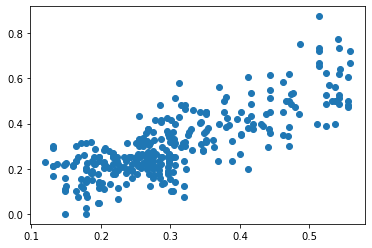

In [9]:
plt.plot(trial_predictions, trial_complexity, 'o')

#### Testing whether frequency feature on its own impacts predictability

In [10]:
linreg.fit(freqCounts, complexity)
predictions = linreg.predict(freqCounts)

# eval on trial data
trial_predictions = linreg.predict(trial_freqCounts)

print("Train R^2:", linreg.score(freqCounts, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))
print("Trial R^2:", linreg.score(trial_freqCounts, trial_complexity))
print("Trial L1:", np.mean(np.abs(trial_predictions - trial_complexity)))



Train R^2: 0.07398706421807888
Train L1: 0.09877410148442772
Trial R^2: 0.07926142162403116
Trial L1: 0.11109627804066761


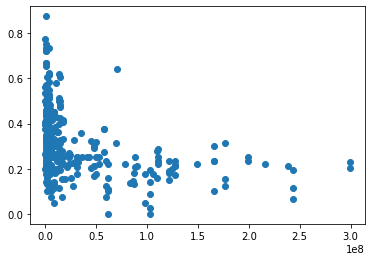

In [45]:
plt.plot(trial_freqCounts, trial_complexity, 'o')

## Feature 2: Number of characters in Word + Glove


In [11]:
#combined with Glove Matrix
training_data = np.append(gloveMatrix, charCounts, axis=1)

linreg.fit(training_data, complexity)
predictions = linreg.predict(training_data)

print("Train R^2:", linreg.score(training_data, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))




Train R^2: 0.614397063924669
Train L1: 0.06467616967779471


In [47]:
# eval on trial data
trial_data = np.append(gloveMatrix_trial, trial_charCounts, axis=1)
trial_predictions = linreg.predict(trial_data)

print("Train R^2:", linreg.score(training_data, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))
print("Trial R^2:", linreg.score(trial_data, trial_complexity))
print("Trial L1:", np.mean(np.abs(trial_predictions - trial_complexity)))


Train R^2: 0.614397063924669
Train L1: 0.06467616967779471
Trial R^2: 0.6165457073595475
Trial L1: 0.07170307563381445


### Combining Feature 1 and Feature 2 + Glove


In [48]:
#Glove matrix + frequency + charCounts feature as final columns
training_data = np.append(gloveMatrix, freqCounts, axis=1)
training_data = np.append(training_data, charCounts, axis=1)

#Training 
clf.fit(training_data, complexity)
predictions = clf.predict(training_data)

print("Train R^2:", clf.score(training_data, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))



Train R^2: 0.6139223717467733
Train L1: 0.06463285102250567


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.62321e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [49]:
# eval on trial data
trial_data = np.append(gloveMatrix_trial, trial_freqCounts, axis=1)
trial_data = np.append(trial_data, trial_charCounts, axis=1)

trial_predictions = clf.predict(trial_data)


print("Train R^2:", clf.score(training_data, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))
print("Trial R^2:", clf.score(trial_data, trial_complexity))
print("Trial L1:", np.mean(np.abs(trial_predictions - trial_complexity)))

Train R^2: 0.6139223717467733
Train L1: 0.06463285102250567
Trial R^2: 0.6201458589665196
Trial L1: 0.07119825953981555


## Feature 3: Capitalization + Glove

In [50]:
#combined with Glove Matrix
training_data = np.append(gloveMatrix, capitalCounts, axis=1)

linreg.fit(training_data, complexity)
predictions = linreg.predict(training_data)

print("Train R^2:", linreg.score(training_data, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))


Train R^2: 0.6201812711686343
Train L1: 0.06402125725578454


In [51]:
# eval on trial data- combined with Glove Matrix
trial_data = np.append(gloveMatrix_trial, trial_capCounts, axis=1)
trial_predictions = linreg.predict(trial_data)

print("Train R^2:", linreg.score(training_data, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))
print("Trial R^2:", linreg.score(trial_data, trial_complexity))
print("Trial L1:", np.mean(np.abs(trial_predictions - trial_complexity)))

Train R^2: 0.6201812711686343
Train L1: 0.06402125725578454
Trial R^2: 0.6261338084386756
Trial L1: 0.07105092988446379


### Combining Feature 1 + Feature 2 + Feature 3 + Glove

In [52]:
#Glove matrix + frequency + charCounts + capitalCounts feature as final columns
training_data = np.append(gloveMatrix, freqCounts, axis=1)
training_data = np.append(training_data, charCounts, axis=1)
training_data = np.append(training_data, capitalCounts, axis=1)

#Training 
clf.fit(training_data, complexity)
predictions = clf.predict(training_data)

print("Train R^2:", clf.score(training_data, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))


Train R^2: 0.6204829102612623
Train L1: 0.06400888034320355


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.61927e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [53]:
# eval on trial data
trial_data = np.append(gloveMatrix_trial, trial_freqCounts, axis=1)
trial_data = np.append(trial_data, trial_charCounts, axis=1)
trial_data = np.append(trial_data, trial_capCounts, axis=1)

trial_predictions = clf.predict(trial_data)

print("Train R^2:", clf.score(training_data, complexity))
print("Train L1:", np.mean(np.abs(predictions - complexity)))
print("Trial R^2:", clf.score(trial_data, trial_complexity))
print("Trial L1:", np.mean(np.abs(trial_predictions - trial_complexity)))

Train R^2: 0.6204829102612623
Train L1: 0.06400888034320355
Trial R^2: 0.6267820710997033
Trial L1: 0.07056499188846044
